In [3]:
import os

import pandas as pd

os.environ["QT_API"] = "pyqt5"

import numpy as np
import matplotlib
import scipy
import matplotlib.pyplot as plt
import matplotlib.widgets as mwidgets

matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt


In [4]:

def pearson(dx, dy):
    return scipy.stats.pearsonr(dx, dy)


def spearman(dx, dy):
    return scipy.stats.spearmanr(dx, dy)


def distance_correlation(dx, dy):
    return dcor.distance_correlation(dx, dy), 0


def timewarping(dx, dy):
    distance, cost_matrix, acc_cost, path = dtw(np.array(dx).reshape(-1, 1), np.array(dy).reshape(-1, 1),
                                                dist=scipy.spatial.distance.euclidean)
    return distance


def corr(df, station, starting_point, interval, method, l, pv, p1):
    period2 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
    for col in df.columns.tolist():
        cor, p_value = method(p1[station], period2[col])
        l.append(cor)
        pv.append(p_value)


def calculate_correlations(df, starting_point, interval, method):
    cross_correlations = []
    for station in df.columns:
        day = pd.Timedelta(1, 'd')
        sp = starting_point
        l = []
        pv = []

        period1 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
        for i in np.linspace(0, 5, 5):
            starting_point = starting_point + day
            corr(df, station, starting_point, interval, method, l, pv, period1)
        starting_point = sp + day
        for i in np.linspace(0, 50, 31):
            starting_point = starting_point - day
            corr(df, station, starting_point, interval, method, l, pv, period1)
        cm = np.transpose(np.reshape(np.array(l), (-1, len(df.columns))))
        pv = np.transpose(np.reshape(np.array(pv), (-1, len(df.columns))))
        cross_correlations.append(cm)
    return cross_correlations



In [5]:
data_training = pd.read_csv("../data/data_training.csv")
data_validation = pd.read_csv('../data/data_validation.csv')

data = pd.concat([data_training, data_validation])
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index('Date')
meta = pd.read_csv("../data/meta.csv")

meta = meta.set_index("reg_number")
meta_nans_removed = meta.loc[list(map(int,data.columns))]

In [6]:
cr = calculate_correlations(data, pd.Timestamp('2005-01-01'), pd.Timedelta(52, 'w'), pearson)

correlation_tensor = {}
for idx, station in enumerate(data.columns):
    correlation_tensor[station] = (pd.DataFrame(data=np.transpose(cr[idx]), columns=data.columns))

print(correlation_tensor['1515'])

correlation_tensor_max_corr = {k: v.idxmax() - 5 for k, v in correlation_tensor.items()}




        1515      1516      1518      1521      1719      1720      1722  \
0   0.948032  0.961216  0.971383  0.947838  0.881199  0.315410  0.862137   
1   0.853993  0.884141  0.926971  0.942456  0.886586  0.347622  0.872581   
2   0.765502  0.791829  0.851599  0.895240  0.863803  0.364640  0.852466   
3   0.699120  0.716504  0.775795  0.832350  0.825903  0.364079  0.818035   
4   0.652985  0.662954  0.714731  0.772750  0.783333  0.351647  0.779625   
5   1.000000  0.974987  0.942949  0.895707  0.835029  0.274838  0.815754   
6   0.948083  0.908940  0.868806  0.821326  0.769664  0.236450  0.754448   
7   0.854223  0.820775  0.790447  0.752710  0.708198  0.205553  0.696896   
8   0.766183  0.742213  0.725623  0.697926  0.659242  0.186929  0.647751   
9   0.700814  0.680816  0.675401  0.655546  0.620841  0.175633  0.607141   
10  0.655046  0.636364  0.636948  0.622443  0.590871  0.165043  0.573122   
11  0.620686  0.601556  0.604919  0.594985  0.566214  0.156710  0.543465   
12  0.590740

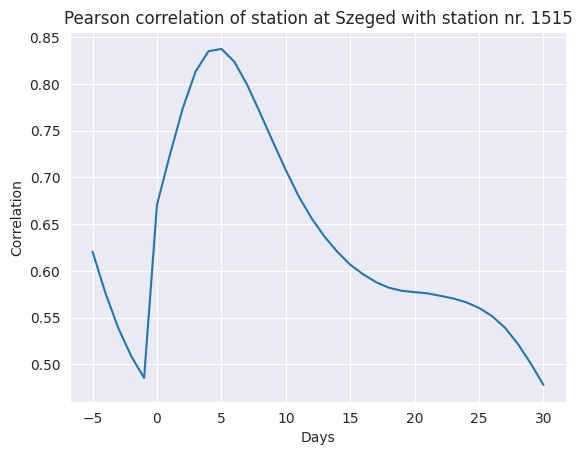

In [16]:
plt.plot(correlation_tensor['2275']['1515'].index - 5,correlation_tensor['2275']['1515'])

plt.xlabel('Days')
plt.ylabel('Correlation')
plt.title('Pearson correlation of station at Szeged with station nr. 1515')

plt.show()

In [7]:
marker_dict = {
    'Tisza': 'o',
    'Maros': 'v',
    'Kettős-Körös': '^',
    'Hármas-Körös': 'x',
    'Szamos': '+',
    'Sebes-Körös' : 'D',
    'Bodrog' : 'h',
    'Túr' : 'd',
    'Sajó' : 'X',
    'Kraszna' : '1',
    'Hernád' : '2',
    'Berettyó': '3',
    'Fekete-Körös' : '4',
    'Fehér-Körös': ',',
    'Zagyva': '<'
}

x_max = meta_nans_removed['EOVx'].max() + 10000
x_min = meta_nans_removed['EOVx'].min() - 10000
y_min = meta_nans_removed['EOVy'].min() + 10000
y_max = meta_nans_removed['EOVy'].max() - 10000

In [8]:
def rgb(val):
    return [[0.4 + min(val * 0.08, 0.6), 0.2, 0.00 + min(abs(val * 0.10), 1.0)]]


def draw(station,slider_value):
    ax.clear()
    stations_to_draw = correlation_tensor_max_corr[station].loc[abs(correlation_tensor_max_corr[station]) <= slider_value]
    for other_station, delay in stations_to_draw.items():
        if station == other_station:
            ax.scatter(meta_nans_removed.loc[int(other_station),'EOVx'], meta_nans_removed.loc[int(other_station),'EOVy'], c=[[0.0,0.9,0.9]], marker=marker_dict[meta_nans_removed.loc[int(other_station),'river']])
        else:
            ax.scatter(meta_nans_removed.loc[int(other_station),'EOVx'], meta_nans_removed.loc[int(other_station),'EOVy'], c=rgb(delay), marker=marker_dict[meta_nans_removed.loc[int(other_station),'river']])

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.show()



In [9]:
def update_plot(text):
    draw(text,slider.val)

def update_slider(val):
    draw(textbox.text,val)

def update(frame):
    draw('2275',frame)


In [10]:
import matplotlib.animation as animation

In [ ]:
fig = plt.figure(figsize=(8, 6))
#gs = matplotlib.gridspec.GridSpec(3, 1, height_ratios=[1, 1, 10])  # Create a GridSpec layout with 3 rows

# Create the plot
ax = plt.subplot()  # Assign the bottom row to the plot
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

# Create a textbox widget
#ax_textbox = plt.subplot(gs[0])  # Assign the top row to the textbox
#textbox = mwidgets.TextBox(ax_textbox, 'Enter coordinates:')

# Create a slider widget
#ax_slider = plt.subplot(gs[1])  # Assign the middle row to the slider
#slider = mwidgets.Slider(ax_slider, 'Slider', 0, 10, valinit=0,valstep=1)

# Register the update functions to be called when the textbox value or slider value changes
#textbox.on_submit(update_plot)
#slider.on_changed(update_slider)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.1)
Writer = animation.writers['imagemagick']
writer = Writer(fps=15, metadata=dict(artist='Me'))

ani = animation.FuncAnimation(fig=fig, func=update, frames=10,interval = 500)
ani.save(filename='corr_animated.gif',writer=writer)
plt.show()



qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [24]:
stations = correlation_tensor_max_corr['1515'].loc[correlation_tensor_max_corr['1515'] <= 0]

In [27]:
for a,b in stations.items():
    print(f"{a}: {b}")

1515: 0
1516: 0
1518: -5
1521: -5
1719: -4
1720: -3
1722: -4
1723: -4
2040: -4
2046: -3
2048: -2
2271: -2
2272: -2
2274: -2
2275: -2
2278: -3
2543: -4
2753: -5
2756: -3
2757: -2
2760: -2
1514: 0
2041: -1
1523: 0
2042: -4
1721: -4
1724: -5
1725: -5
2744: 0
2748: 0
2759: -3
1520: -5
1527: 0
2541: -4
1530: 0
1734: 0
2741: -4
2742: -4
2751: -5
2545: 0
744624: -3
210888: -1
210900: -1


In [52]:
draw('1515',9)

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


KeyboardInterrupt: 